# Practice Session 05: PageRank

*Introduction to Network Science* (2025/26), UPF

# 1. Read host names

In [1]:
# Imports — leave as is

import gzip
import csv
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Input file locations — you might need to change these depending on where you stored your files

INPUT_NODES_FILENAME = "data/webspam-uk2007/webspam_uk2007-nodes.csv.gz"
INPUT_EDGES_FILENAME = "data/webspam-uk2007/webspam_uk2007-edges.csv.gz"

In [3]:
hosts = {}
name2id = {}

In [4]:

with gzip.open(INPUT_NODES_FILENAME, "rt", encoding="utf-8") as nodes_file:
    reader = csv.DictReader(nodes_file, delimiter=",", quotechar='"')
    for row in reader:          # Read each row from the CSV file
        nodeid = int(row["nodeid"]) # Convert nodeid to int
        hostname = row["hostname"] # get hostname
        label = row["label"] # get label
        hosts[nodeid] = {"name": hostname, "label": label} # First dictionary maps nodeid to hostname and label
        name2id[hostname] = nodeid # Second dictionary maps hostname to nodeid

In [5]:
# Leave as-is

print("Number of hosts: %s" % len(hosts))
print("%s: %s" % (hosts[873]['name'], hosts[873]['label']))
print("%s: %s" % (hosts[105715]['name'], hosts[105715]['label']))

Number of hosts: 114529
bbc.co.uk: nonspam
www.top-mobile-phones.co.uk: spam


In [6]:
spam = 0
non = 0
un = 0
for i in range(len(hosts)):
    if hosts[i]['label'] == "spam":
        spam += 1
    elif hosts[i]['label'] == "nonspam":
        non += 1
    elif hosts[i]['label'] == "unlabeled":
        un += 1

print(f"Number of spam: {spam:,}")
print(f"Number of nonspam: {non:,}")
print(f"Number of unlabeled: {un:,}")
all = spam + non + un
print(f"Total: {all - len(hosts)} (should be 0)")

print(f"Percentage of spam: {spam/all*100:.1f}%")
print(f"Percentage of nonspam: {non/all*100:.1f}%")
print(f"Percentage of unlabeled: {un/all*100:.1f}%")

Number of spam: 344
Number of nonspam: 5,709
Number of unlabeled: 108,476
Total: 0 (should be 0)
Percentage of spam: 0.3%
Percentage of nonspam: 5.0%
Percentage of unlabeled: 94.7%


In [7]:
with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as edges_file:
    for i in range(10):
        print(edges_file.readline().strip())

source,destination,weight
0,1005,1
0,8306,1
0,9596,1
0,10056,1
0,10981,1
0,18571,1
0,22236,1
0,24284,1
0,26724,3


In [8]:
spammywords = ['credit', 'free', 'mortgage', 'jackpot', 'casino', 'wealthy', 'luxury', 'shop', 'replica', 'finance', 'debt', 'loan', 'discount', 'escort', 'xx', 'girl', 'mistress', 'important', 'attention']

In [9]:
g = nx.DiGraph()

with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as edges_file:
    reader = csv.DictReader(edges_file, delimiter=",", quotechar='"')
    for row in reader:
        # First take source and destination node IDs from the row
        source = int(row["source"])
        destination = int(row["destination"])
        weights = int(row["weight"])
        
        # Then get the corresponding hostnames and labels
        src_name = hosts[source]["name"]
        dst_name = hosts[destination]["name"]

        # Get the corresponding labels
        src_label = hosts[source]["label"]
        dst_label = hosts[destination]["label"]

        # Check spammywords in source or destination hostname
        if (any(word in src_name for word in spammywords) or any(word in dst_name for word in spammywords)):
            # Only consider spam/nonspam labels
            if src_label in ("spam", "nonspam") and dst_label in ("spam", "nonspam"):
                g.add_edge(src_name, dst_name, weight = weights)

print("Number of nodes:", len(g.nodes))

Number of nodes: 172


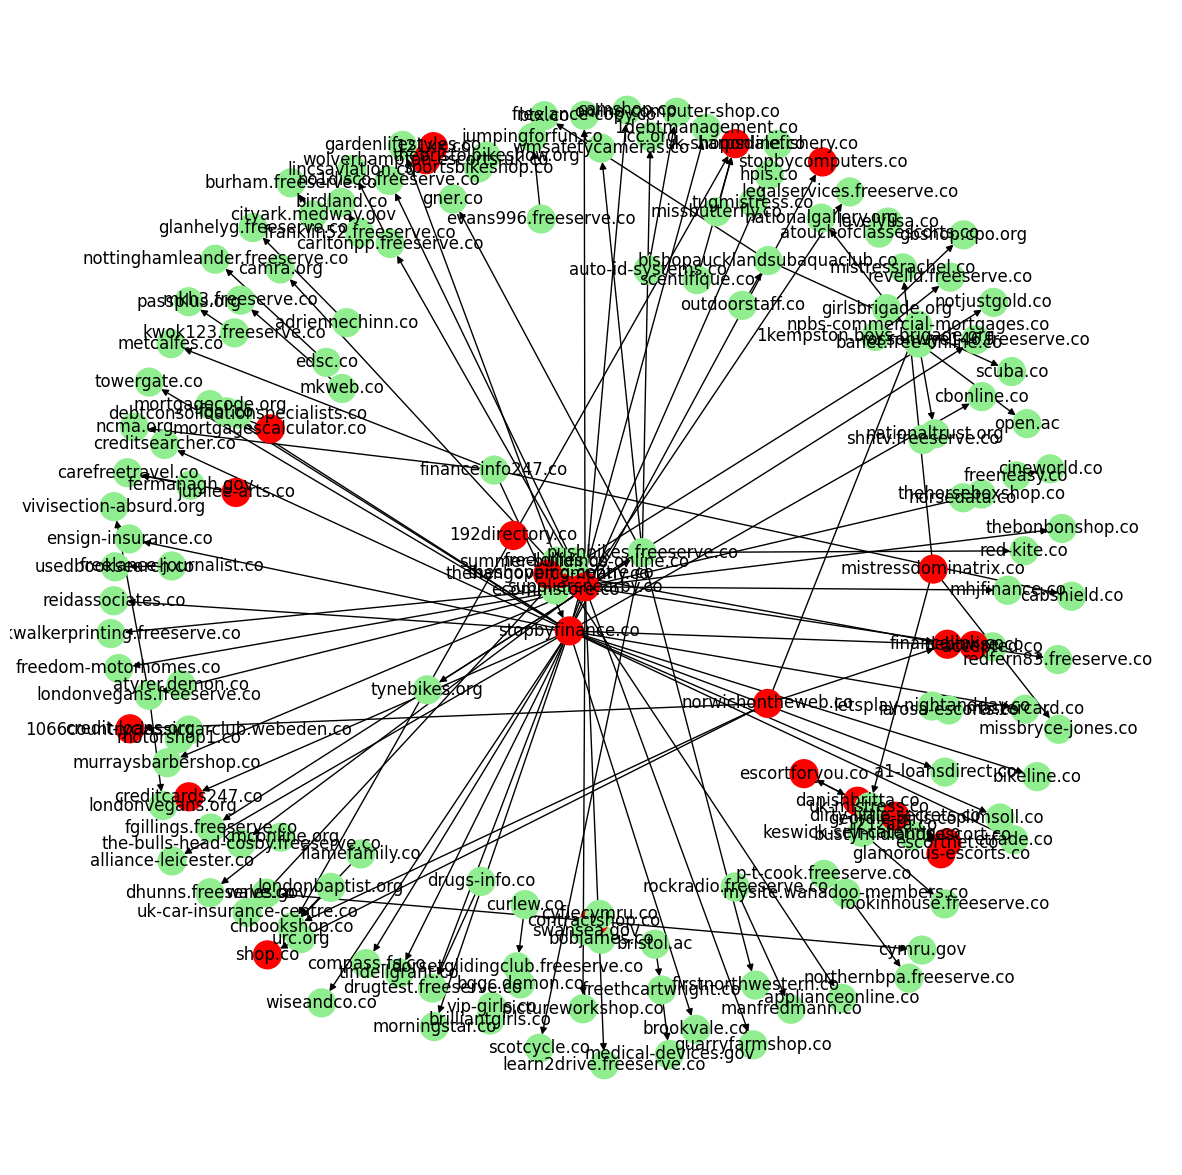

In [10]:
# Leave this code as-is, or modify slightly

colors = []
hostname_converted = {}

for hostname in g.nodes():
    # Assign colors to nodes according to spam/nonspam labels
    if hosts[name2id[hostname]]['label'] == 'spam':
        colors.append('red')
    elif hosts[name2id[hostname]]['label'] == 'nonspam':
        colors.append('lightgreen')
    else:
        colors.append('white')

    # Shorten the hostnames to generate labels
    label = hostname.replace("www.", "").replace(".uk", "")
    hostname_converted[hostname] = label

# Notice that if you re-run this cell the layout will be different every time
plt.figure(figsize=(15, 15))
plt.axis('off')
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True, node_size=400, node_color=colors, labels=hostname_converted)

Node positions reflect connectivity (closer = more strongly connected)

Node colors: red = spam, light green = nonspam, white = unlabeled.

labels are shortened hostnames (www./.uk removed)

Red (spam) nodes form clusters and frequently link to nonspam nodes 

Network appears to be sparse with a small center containing a mix of both spam and nonspam nodes

In [11]:
# Count edges for probability calculations
total_edges = g.number_of_edges()
spam_src_edges = 0
spam_to_nonspam_edges = 0

for src, dst in g.edges():
    src_label = hosts[name2id[src]]['label']
    dst_label = hosts[name2id[dst]]['label']
    if src_label == 'spam':
        spam_src_edges += 1
        if dst_label == 'nonspam':
            spam_to_nonspam_edges += 1

# Marginal probability: edge from spam node
p_spam_src = spam_src_edges / total_edges if total_edges else 0

# Joint probability: edge from spam to nonspam
p_spam_to_nonspam = spam_to_nonspam_edges / total_edges if total_edges else 0

# Conditional probability: spam->nonspam given spam source
p_spam_to_nonspam_given_spam = spam_to_nonspam_edges / spam_src_edges if spam_src_edges else 0

print(f"P(edge from spam): {p_spam_src:.3f}")
print(f"P(edge from spam to nonspam): {p_spam_to_nonspam:.3f}")
print(f"P(edge to nonspam | spam source): {p_spam_to_nonspam_given_spam:.3f}")

P(edge from spam): 0.497
P(edge from spam to nonspam): 0.381
P(edge to nonspam | spam source): 0.766


These probabilities make sense, we have constructed a graph that necessitates at least some element of spamminess (spammywords must be in at least one node), so the probability of having an edge from spam must be much higher than the prevalence of spam within the whole dataset. Also, spam sources will tend to link to nonspam pages in hopes being deemed nonspam by detection probes, so the probability being around 3/4ths seems to make sense.

# 2. Compute the degree of each node

In [12]:
# Leave this code as-is

# Initialize id2degree dict
id2degree = {}
N = len(hosts)
for nodeid in range(N):
    id2degree[nodeid] = 0

In [13]:
with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as edges_file:
    reader = csv.DictReader(edges_file, delimiter=",", quotechar='"')
    for row in reader:
        source = int(row["source"])
        destination = int(row["destination"])
        weight = int(row["weight"])
        id2degree[source] += 1    # Use +1 for out-degree rather than weight

In [14]:
# Leave this cell as-is

for nodeid in [61914, 479, 62730]:
    print(f"{hosts[nodeid]['name']}: degree {id2degree[nodeid]}")

www.instrumentfinance.co.uk: degree 262
amazon.co.uk: degree 6
www.iso9000uk.co.uk: degree 38


# 3. Compute PageRank

In [15]:
# Leave this cell as-is

ITERATIONS = 25
ALPHA = 0.91

pagerank = [1.0/N] * N
pagerank_aux = [0.0] * N

In [ ]:
for iteration in range(ITERATIONS):
    print(f"Iteration {iteration+1} of {ITERATIONS}")

    with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
        reader = csv.DictReader(input_file, delimiter=",", quotechar='"')
        
        for row in reader:
            source = int(row["source"])
            destination = int(row["destination"])
            if id2degree[source] > 0:
                pagerank_aux[destination] += pagerank[source] / id2degree[source]
    
    # Apply damping factor and random jump
    for nodeid in range(N):
        pagerank_aux[nodeid] = ALPHA * pagerank_aux[nodeid] + (1.0 - ALPHA) / N
    
    # Normalize pagerank
    norm = sum(pagerank_aux)
    pagerank_aux = [x / norm for x in pagerank_aux]

#]

    # Compute delta
    delta = sum(abs(pagerank[nodeid] - pagerank_aux[nodeid]) for nodeid in range(N))
    print(f"Delta: {delta:.4f}")
    pagerank, pagerank_aux = pagerank_aux, [0.0] * N

Iteration 1 of 25
Delta: 1.1472
Iteration 2 of 25
Delta: 0.4814
Iteration 3 of 25
Delta: 0.2268
Iteration 4 of 25
Delta: 0.1259
Iteration 5 of 25
Delta: 0.0798
Iteration 6 of 25
Delta: 0.0548
Iteration 7 of 25
Delta: 0.0400
Iteration 8 of 25
Delta: 0.0302
Iteration 9 of 25
Delta: 0.0240
Iteration 10 of 25
Delta: 0.0197
Iteration 11 of 25
Delta: 0.0169
Iteration 12 of 25
Delta: 0.0153
Iteration 13 of 25
Delta: 0.0147
Iteration 14 of 25
Delta: 0.0146
Iteration 15 of 25
Delta: 0.0145
Iteration 16 of 25
Delta: 0.0145
Iteration 17 of 25
Delta: 0.0146
Iteration 18 of 25
Delta: 0.0147
Iteration 19 of 25
Delta: 0.0148
Iteration 20 of 25
Delta: 0.0150
Iteration 21 of 25
Delta: 0.0151
Iteration 22 of 25
Delta: 0.0153
Iteration 23 of 25
Delta: 0.0155
Iteration 24 of 25
Delta: 0.0157
Iteration 25 of 25
Delta: 0.0159


# 4. Nodes with largest values of PageRank

In [ ]:
def print_top_hosts_by_pagerank(pagerank, hosts, top=20):
    """
    Print the top `top` hosts by PageRank.
    Prints: rank, hostname, label, score (6 decimals).
    Returns list of (nodeid, score) for the top hosts.
    """
    hosts_by_score = sorted(enumerate(pagerank), key=lambda x: x[1], reverse=True)
    for rank, (nodeid, score) in enumerate(hosts_by_score[:top], start=1):
        name = hosts[nodeid]['name']
        label = hosts[nodeid]['label']
        print(f"{rank:2d}. {name:40s} {label:8s} {score:.6f}")
    return hosts_by_score[:top]



In [19]:
# Print top 20 hosts by PageRank
top20 = print_top_hosts_by_pagerank(pagerank, hosts, top=20)

 1. www.opsi.gov.uk                          unlabeled 0.006525
 2. www.ico.gov.uk                           unlabeled 0.003838
 3. www.adobe.co.uk                          unlabeled 0.003396
 4. www.kelkoo.co.uk                         unlabeled 0.003389
 5. www.dti.gov.uk                           unlabeled 0.003127
 6. www.alcoholics-anonymous.org.uk          unlabeled 0.003107
 7. www.defra.gov.uk                         unlabeled 0.003014
 8. shopping.kelkoo.co.uk                    unlabeled 0.002892
 9. www.aa-roundabout.org.uk                 unlabeled 0.002830
10. www.direct.gov.uk                        unlabeled 0.002611
11. www.communities.gov.uk                   unlabeled 0.002606
12. www.dfes.gov.uk                          unlabeled 0.002486
13. www.dh.gov.uk                            unlabeled 0.002120
14. www.hmso.gov.uk                          unlabeled 0.001994
15. news.bbc.co.uk                           unlabeled 0.001990
16. www.fsa.gov.uk                      

1) Why these sites rank top.
PageRank favors nodes with many incoming links from diverse parts of the graph. Large government portals, national services and well known brands receive many inbound links across the web, so they accumulate higher PageRank scores.
The high damping factor (ALPHA = 0.91) amplifies the importance of link structure, giving more benefits to authoritative hubs (gov pages, big orgs, major commercial sites).
Most of the listed sites are central reference/aggregation pages (official guidance, news, national services) that attract links from many smaller sites, which explains their high scores.

2) Category percentages among the top 20.
Government (.gov.uk): 13/20 = 65.0%.
Commercial: 4/20 = 20.0%.
Educational: 0/20 = 0.0%.
Other (nonprofit, public broadcaster, local clubs): 3/20 = 15.0%.

# 5. Run non-spam PageRank

In [ ]:
# Compute no-spam out-degree: ignore edges where either source or destination is labeled 'spam'
id2nsdegree = {nodeid: 0 for nodeid in range(N)}

with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as edges_file:
    reader = csv.DictReader(edges_file, delimiter=",", quotechar='"')

    for row in reader:
        
        source = int(row["source"])
        destination = int(row["destination"])
        
        # skip edges where either end is known spam
        if hosts[source]['label'] == 'spam' or hosts[destination]['label'] == 'spam':
            continue
        
        id2nsdegree[source] += 1

In [23]:
# Leave this cell as-is

for nodeid in [61914, 479, 62730]:
    print(f"{hosts[nodeid]['name']}: normal degree {id2degree[nodeid]} nospam degree {id2nsdegree[nodeid]}")

www.instrumentfinance.co.uk: normal degree 262 nospam degree 258
amazon.co.uk: normal degree 6 nospam degree 6
www.iso9000uk.co.uk: normal degree 38 nospam degree 37


In [24]:
# Compute non-spam PageRank (nspagerank)
nspagerank = [1.0 / N] * N
nspagerank_aux = [0.0] * N

for iteration in range(ITERATIONS):
    print(f"Non-spam PageRank: Iteration {iteration+1} of {ITERATIONS}")
    with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
        reader = csv.DictReader(input_file, delimiter=",", quotechar='"')
        for row in reader:
            source = int(row["source"])
            destination = int(row["destination"])

            # ignore edges where either end is known spam
            if hosts[source]['label'] == 'spam' or hosts[destination]['label'] == 'spam':
                continue

            deg = id2nsdegree[source]
            if deg > 0:
                nspagerank_aux[destination] += nspagerank[source] / deg

    # apply damping and random jump
    for nodeid in range(N):
        nspagerank_aux[nodeid] = ALPHA * nspagerank_aux[nodeid] + (1.0 - ALPHA) / N

    # normalize
    norm = sum(nspagerank_aux)
    if norm == 0.0:
        nspagerank_aux = [1.0 / N] * N
    else:
        nspagerank_aux = [x / norm for x in nspagerank_aux]

    # compute and print delta
    delta_ns = sum(abs(nspagerank[i] - nspagerank_aux[i]) for i in range(N))
    print(f"Delta (non-spam): {delta_ns:.4f}")

    # prepare for next iteration
    nspagerank, nspagerank_aux = nspagerank_aux, [0.0] * N

# nspagerank now contains the no-spam PageRank vector

Non-spam PageRank: Iteration 1 of 25
Delta (non-spam): 1.1480
Non-spam PageRank: Iteration 2 of 25
Delta (non-spam): 0.4816
Non-spam PageRank: Iteration 3 of 25
Delta (non-spam): 0.2267
Non-spam PageRank: Iteration 4 of 25
Delta (non-spam): 0.1260
Non-spam PageRank: Iteration 5 of 25
Delta (non-spam): 0.0799
Non-spam PageRank: Iteration 6 of 25
Delta (non-spam): 0.0548
Non-spam PageRank: Iteration 7 of 25
Delta (non-spam): 0.0400
Non-spam PageRank: Iteration 8 of 25
Delta (non-spam): 0.0303
Non-spam PageRank: Iteration 9 of 25
Delta (non-spam): 0.0240
Non-spam PageRank: Iteration 10 of 25
Delta (non-spam): 0.0197
Non-spam PageRank: Iteration 11 of 25
Delta (non-spam): 0.0169
Non-spam PageRank: Iteration 12 of 25
Delta (non-spam): 0.0153
Non-spam PageRank: Iteration 13 of 25
Delta (non-spam): 0.0147
Non-spam PageRank: Iteration 14 of 25
Delta (non-spam): 0.0146
Non-spam PageRank: Iteration 15 of 25
Delta (non-spam): 0.0146
Non-spam PageRank: Iteration 16 of 25
Delta (non-spam): 0.0146
N

In [25]:
# Print top 20 hosts by no-spam PageRank
top20_ns = print_top_hosts_by_pagerank(nspagerank, hosts, top=20)

 1. www.opsi.gov.uk                          unlabeled 0.006532
 2. www.ico.gov.uk                           unlabeled 0.003839
 3. www.kelkoo.co.uk                         unlabeled 0.003398
 4. www.adobe.co.uk                          unlabeled 0.003397
 5. www.dti.gov.uk                           unlabeled 0.003130
 6. www.alcoholics-anonymous.org.uk          unlabeled 0.003113
 7. www.defra.gov.uk                         unlabeled 0.003015
 8. shopping.kelkoo.co.uk                    unlabeled 0.002899
 9. www.aa-roundabout.org.uk                 unlabeled 0.002836
10. www.direct.gov.uk                        unlabeled 0.002611
11. www.communities.gov.uk                   unlabeled 0.002609
12. www.dfes.gov.uk                          unlabeled 0.002490
13. www.dh.gov.uk                            unlabeled 0.002125
14. www.hmso.gov.uk                          unlabeled 0.001997
15. news.bbc.co.uk                           unlabeled 0.001991
16. www.fsa.gov.uk                      

## Brief commentary

- PageRank runs:
    - Standard PageRank and non-spam PageRank were computed by iterating over the edges file each iteration (no full graph stored).
    - Convergence behaved as expected (delta decreased each iteration); final per-iteration deltas were ~0.0159 (normal) and ~0.0160 (no-spam).
    - Top-20 lists for both versions were produced; many top hosts stay similar, but some sites change rank when spam links are removed.

- Takeaway: removing spam-related links produces measurable but often modest rank shifts; the largest effects concentrate on hosts that either receive or route many spam-targeted links. Spam gain might help to quantify the vulnerability below.

# 6. Compute spam gain

In [26]:
# Compute spam gain and print top 50 hosts by gain
# Gain = (Normal PageRank) / (No-spam PageRank)

gains = []
for nodeid in range(N):
    pr = pagerank[nodeid]
    ns = nspagerank[nodeid]
    if ns == 0.0:
        # If no-spam PageRank is zero but normal PR > 0, treat gain as infinite
        gain = float('inf') if pr > 0.0 else 0.0
    else:
        gain = pr / ns
    gains.append((nodeid, gain, pr, ns))

# sort by gain descending (inf will come first)
gains_sorted = sorted(gains, key=lambda x: x[1], reverse=True)

print(f"Top 50 hosts by spam gain (NormalPR / NoSpamPR):\n")
for rank, (nodeid, gain, pr, ns) in enumerate(gains_sorted[:50], start=1):
    name = hosts[nodeid]['name']
    label = hosts[nodeid]['label']
    # gain with two decimals, pagerank and no-spam pagerank in scientific with two significant digits
    print(f"{rank:2d}. {name:40s} {label:8s} gain {gain:.2f}  pr {pr:.2g}  nspr {ns:.2g}")

Top 50 hosts by spam gain (NormalPR / NoSpamPR):

 1. www.missionfish.org.uk                   spam     gain 147.00  pr 0.00013  nspr 8.9e-07
 2. www.into.demon.co.uk                     spam     gain 146.69  pr 0.00013  nspr 8.9e-07
 3. www.statistics.006.free-counter.co.uk    spam     gain 132.21  pr 0.00012  nspr 8.9e-07
 4. www.escortnet.co.uk                      spam     gain 122.29  pr 0.00011  nspr 8.9e-07
 5. www.aili.co.uk                           unlabeled gain 109.99  pr 0.00012  nspr 1.1e-06
 6. www.hertfordshiremobilediscos.co.uk      spam     gain 85.26  pr 7.5e-05  nspr 8.9e-07
 7. www.jlc.me.uk                            spam     gain 73.60  pr 6.5e-05  nspr 8.9e-07
 8. www.geordie-girls.co.uk                  spam     gain 46.56  pr 4.1e-05  nspr 8.9e-07
 9. www.kompass.co.uk                        spam     gain 35.55  pr 3.1e-05  nspr 8.9e-07
10. www.uk-shoponline.co.uk                  spam     gain 34.95  pr 3.1e-05  nspr 8.9e-07
11. www.ideas21.co.uk             

- Definition: spam gain = (Normal PageRank) / (No‑spam PageRank). It measures how much a host's PageRank increases because of links that involve known spam hosts (a value >1 means the host benefits from spammy links).

- What high spam‑gain sites look like: domains that receive many inbound links from spam farms and other spammy businesses. Legitimate sites that are heavily targeted by spammers could also appear here but we don't see any present, except aili.co.uk which is unlabelled

- Effects of using non‑spam PageRank:
    - Reduces the influence of spam links, so sites that relied on spam see their ranks drop; non‑manipulated sites tend to retain or improve relative position.
    - Can reveal which hosts are being 'boosted' by spam (useful for detection/mitigation).
    - Potential for smaller legitimate sites to be negatively affected by changing the network, leaving them more isolated and thus lowering their rank

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>